# Principal component analysis
Principal component analysis (PCA) is useful for data reduction and feature extraction. PCA transforms a dataset with a large number of features into a smaller set of new features called principal components. The principal components are linear combinations of the original features that capture the maximum amount of variation in the data. PCA lets us reduce the dimensions of a complicated feature space, which reduces model complexity and mitigates risks of overfitting. PCA can be used for a variety of tasks such as data visualization, dimensionality reduction, and noise reduction.

We will implement PCA from scratch to find the principal components of the 7 data features of each LEGO set in the LEGO database: pieces, weight, width, height, depth, recommended retail USD price (RRP), USD value.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Read in dataset and keep relevant columns/rows
df = pd.read_csv('../Data/Brickset-Most-Owned-Query-33-02042023.csv', index_col="Number")
df = df.filter(["Theme", "Pieces", "Weight", "Width", "Height", "Depth", "RRP (USD)", "Value new (USD)"])
df.columns = ["Theme", "Pieces", "Weight", "Width", "Height", "Depth", "RRP", "Value"]
df = df.dropna()
print(df.head())

# Get dataframe of only the data features
features = df.drop("Theme", axis=1)

                   Theme  Pieces  Weight   Width   Height    Depth     RRP  \
Number                                                                       
75252-1        Star Wars  4784.0   12.42  53.300  46.0000  38.5000  699.99   
10214-1  Advanced models  4287.0    4.35  58.200  48.0000  12.7000  239.99   
10261-1   Creator Expert  4124.0    5.80  58.100  48.6000  18.6000  379.99   
42082-1          Technic  4057.0    6.10  58.200  48.0000  17.0000  299.99   
10188-1        Star Wars  3803.0    8.31  58.801  50.1904  17.6022  399.99   

          Value  
Number           
75252-1  715.71  
10214-1  269.34  
10261-1  365.50  
42082-1  244.70  
10188-1  617.55  


## Implementation
Our implementation of PCA follows the tutorial by [Dario Radečić](https://towardsdatascience.com/principal-component-analysis-pca-from-scratch-in-python-7f3e2a540c51). The steps are as follows:
1. Normalize the data. This ensures the PCA is not disproportionately sensitive to one feature over another. Here, we will chose to scale and translate the data such that each feature has zero mean and unit variance.
2. Calculate the covariance matrix of the data features.
3. Eigendecomposition: The pricipal components are the eigenvectors of the covariance matrix, and the "impact/usefulness" of each principal component is proportionate to its associated eigenvalue.
4. Transform the original data into the principal component space by multiplying the data matrix by the matrix whose columns are the (unit) eigenvectors.

In [2]:
def pca(data):
    '''
    Performs principal component analysis on the input array of data features.
    INPUT
        data; (n, m)-shape numpy array, representing n data observations on m features
    RETURNS
        (m, m)-shape numpy array, where the columns are the principal components
        (m, )-shape numpy series, where the ith entry is the proportion of data variance explained by the ith principal component
        (n, m)-shape numpy array, representing the input data features after transforming to the principal component space
    '''
    
    # Normalize the data
    scaled_data = StandardScaler().fit_transform(data)
    
    # Compute covariance matrix
    covariance = np.cov(scaled_data.transpose())
    
    # Eigendecomposition
    evalues, evectors = np.linalg.eig(covariance)
    
    # Scale eigenvalues such that they sum to 1. 
    # This way, each eigenvalue represents the proportion of data variance explained by its associated principal component.
    evalues = evalues / np.sum(evalues)
    
    # Sort principal components by the magnitude of the associated eigenvalues
    order = np.argsort(-evalues)
    evalues = evalues[order]
    evectors = evectors[:, order]
    
    # Transform data matrix into principal component space
    transformed_data = np.matmul(scaled_data, evectors)
    
    return evectors, evalues, transformed_data

In [3]:
principal_components, explained_variance, pca_features = pca(features)

## Evaluating the principal components
Great! One way to evaluate a PCA is using a scree plot. A scree plot displays the eigenvalues of each principal component in descending order. The scree plot is a useful tool for determining the optimal number of principal components to retain because it allows us to visualize the proportion of variance explained by each principal component. Retaining too many principal components can lead to overfitting, while retaining too few can result in information loss. Therefore, the scree plot helps us to strike a balance between retaining enough information while still reducing the dimensionality of the data.

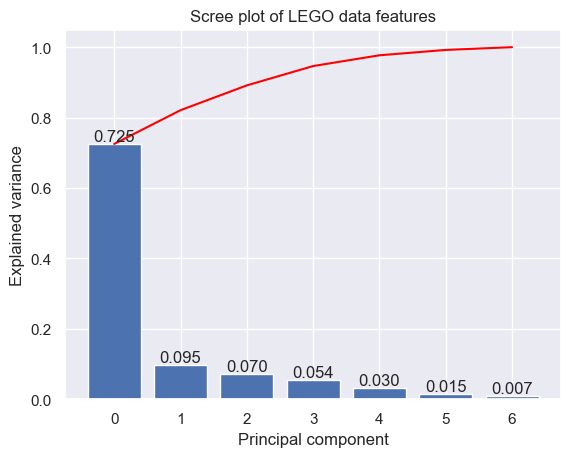

In [4]:
sns.set_theme()

# Plot explained variance for each principal component
plt.bar(range(len(explained_variance)), explained_variance)

# Plot cumulative explained variance
plt.plot(np.cumsum(explained_variance), c="red")

# Add data labels
for ind, val in enumerate(explained_variance):
    plt.text(ind, val, str(val)[:5],
             horizontalalignment="center",
             verticalalignment="bottom")

# Add axes labels
plt.xlabel("Principal component")
plt.ylabel("Explained variance")
plt.title("Scree plot of LEGO data features")
plt.show()

Looks like the 0th principal component is very impactful, explaining 72.5% of variation in the data. The other principal components are much less impactful; the next best principal component only explains 9.5% of variation in the data.

When selecting the optimal number of principal components to use, we want to select as few principal components as possible while still explaining a significant amount of variance. The "elbow method" is popular: choose principal components until the explained variance begins to drop off/flatten. Here, our "elbow" is located at principal component 1.

Let's select two principal components (PC 0 and 1) as our set of optimal principal components. These two principal components collectively account for 82% of the total variation in the data. Observe the below scatterplot of the LEGO sets on these two principal components.

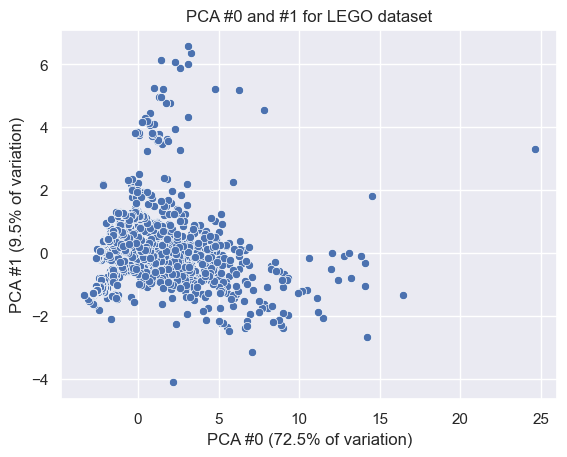

In [5]:
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1])
plt.xlabel("PCA #0 (72.5% of variation)")
plt.ylabel("PCA #1 (9.5% of variation)")
plt.title("PCA #0 and #1 for LEGO dataset")
plt.show()

Throughout our overall project, we have been interested in classifying the theme of LEGO sets. We have been particularly interested in classifying Duplo-, Bionicles-, and Education-theme LEGO sets. Let's filter out all data points that are not from one of these three themes.

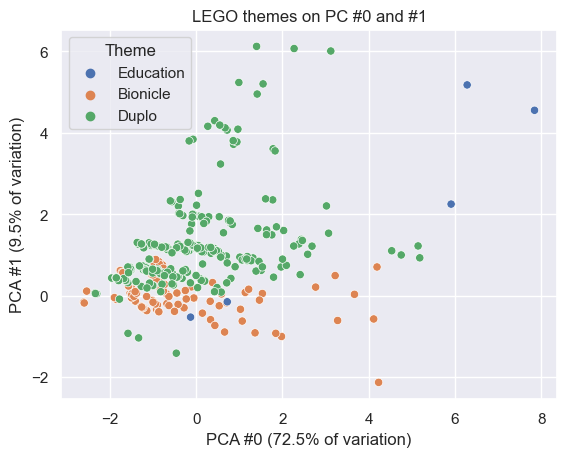

In [6]:
theme = np.where(df["Theme"] == "Duplo", "Duplo",
        np.where(df["Theme"] == "Bionicle", "Bionicle",
        np.where(df["Theme"] == "Education", "Education", "Other")))

filtered_pca_features = pca_features[(df["Theme"] == "Duplo")
                                     | (df["Theme"] == "Bionicle")
                                     | (df["Theme"] == "Education")]

filtered_theme = df.Theme[(df["Theme"] == "Duplo")
                          | (df["Theme"] == "Bionicle")
                          | (df["Theme"] == "Education")]


sns.scatterplot(x=filtered_pca_features[:, 0], y=filtered_pca_features[:, 1], hue=filtered_theme)
plt.xlabel("PCA #0 (72.5% of variation)")
plt.ylabel("PCA #1 (9.5% of variation)")
plt.title("LEGO themes on PC #0 and #1")
plt.show()

On our two PCs, we see good separation of the Duplo and Bionicle sets. Furthermore, the Education sets seem to be somewhat separated from the other two. Unfortunately, we only have 5 Education observations because we lost many data points when we called `df.dropna()` earlier.

As a comparision, this is what the LEGO sets look like when plotted on the pieces and weight features.

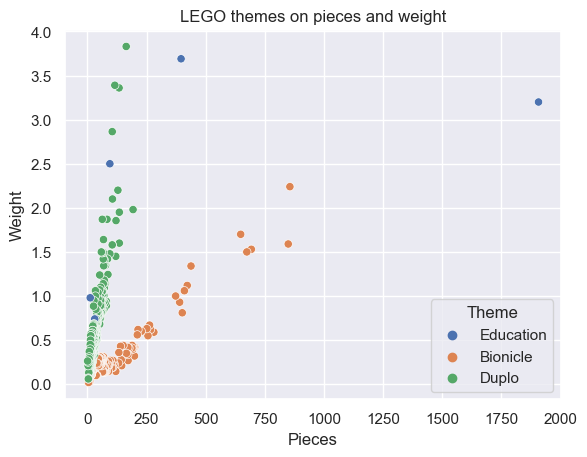

In [7]:
sns.scatterplot(x=df.Pieces[(df["Theme"] == "Duplo") | (df["Theme"] == "Bionicle") | (df["Theme"] == "Education")],
                y=df.Weight[(df["Theme"] == "Duplo") | (df["Theme"] == "Bionicle") | (df["Theme"] == "Education")], 
                hue=filtered_theme)
plt.xlabel("Pieces")
plt.ylabel("Weight")
plt.title("LEGO themes on pieces and weight")
plt.show()

From here, we can perform any of the classification models we have discussed elsewhere.